<a href="https://colab.research.google.com/github/BlackCurrantDS/DBSE_Project/blob/main/Part3_Clustering_DBSCAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook takes feature vectors of each rules and also frequent itemsets perfroms DBSCAN on it to get noise points.


Loading Feature vector

In [50]:
def string_2_itemset(key):
    if key == '':
        return []
    else: 
        return key.split(',')

def itemset_2_string(itemset):
    return ",".join(itemset)

In [51]:


class AssociationRule:
    def __init__(self, left, right):
        self.left_items = left
        self.right_items = right
        self.scores = []
        
    def length(self):
        return len(self.left_items) + len(self.right_items)
     
    def score(self, index):
        return self.scores[index]
    
    def lhs_string(self):
        return itemset_2_string(self.left_items)
        
    def rhs_string(self):
        return itemset_2_string(self.right_items)
    
    def serialize(self):
        left_key = self.lhs_string()
        right_key = self.rhs_string()
        return left_key + ">" + right_key
    
    @staticmethod        
    def string_2_rule(s):
        subStrings = s.split(">")
        left = string_2_itemset(subStrings[0].strip())
        right = string_2_itemset(subStrings[1].strip())
        #print("AssociationRule(left, right",AssociationRule(left, right))
        return AssociationRule(left, right)

    def append_score(self, score):
        self.scores.append(score)
        
    def get_itemset(self):
        itemset = []
        itemset.extend(self.left_items)
        itemset.extend(self.right_items)
        itemset.sort()
        return itemset
        
        
    def rule_itemset_2_string(self):
        itemset = self.get_itemset()
        return itemset_2_string(itemset)
    
    def compute_basic_probs(self,frequent_itemsets, nTransactions):  
        
        left = frequent_itemsets[self.lhs_string()]
        right = frequent_itemsets[self.rhs_string()]
        
        both = frequent_itemsets[self.rule_itemset_2_string()]
        
        vector = {}
        
        ''' 1. P(A)'''
        p_A = left/nTransactions
        vector['A'] = p_A
        
        ''' 2. P(B)'''
        p_B = right/nTransactions
        vector['B'] = p_B
        
        ''' 3. P(~A)'''
        p_not_A = 1 - p_A
        vector['~A'] = p_not_A
        
        ''' 4. P(~B)'''
        p_not_B = 1 - p_B
        vector['~B'] = p_not_B
        
        ''' 5. P(AB) '''
        p_A_and_B = both/nTransactions
        vector['AB'] = p_A_and_B
        
        ''' 6. P(~AB)'''
        p_not_A_and_B = (right - both)/nTransactions
        vector['~AB'] = p_not_A_and_B
        
        ''' 7. P(A~B)'''
        p_A_and_not_B = (left - both)/nTransactions
        vector['A~B'] = p_A_and_not_B
        
        ''' 8. P(~A~B)'''
        p_not_A_and_not_B = 1 - (left + right - both)/nTransactions
        vector['~A~B'] = p_not_A_and_not_B 
        
        '''
        9. P(A|B)
        '''
        p_A_if_B = p_A_and_B / p_B
        vector['A|B'] = p_A_if_B
        
        '''
        10. P(~A|~B)
        '''
        p_not_A_if_not_B = p_not_A_and_not_B / p_not_B
        vector['~A|~B'] = p_not_A_if_not_B
        
        '''
        11. P(A|~B)
        '''
        p_A_if_not_B = p_A_and_not_B/p_not_B
        vector['A|~B'] = p_A_if_not_B
        
        '''
        12. p(~A|B)
        '''
        p_not_A_if_B = p_not_A_and_B / p_B
        vector['~A|B'] = p_not_A_if_B
        
        '''
        13. P(B|A)
        '''
        p_B_if_A = p_A_and_B / p_A
        vector['B|A'] = p_B_if_A
        
        '''
        14. P(~B|~A)
        '''
        p_not_B_if_not_A = p_not_A_and_not_B / p_not_A
        vector['~B|~A'] = p_not_B_if_not_A
        
        '''
        15. P(B|~A)
        '''
        p_B_if_not_A = p_not_A_and_B/p_not_A
        vector['B|~A'] = p_B_if_not_A
        
        '''
        16. p(~B|A)
        '''
        p_not_B_if_A = p_A_and_not_B / p_A
        vector['~B|A'] = p_not_B_if_A
        
        return vector
    
    def is_redundant_(self, bits, k, itemset, freq_itemset_dict): 
        '''
        Run out of items --> create rule and check format criterion
        '''
        if k >= len(itemset):
            items_1 = []
            items_2 = []
            for index in range(len(bits)):
                if bits[index] == True:
                    items_1.append(itemset[index])
                else:
                    items_2.append(itemset[index])
            for item in items_2:
                rule = AssociationRule(items_1, [item])
                confidence = freq_itemset_dict.getConfidence(rule)
                if confidence == 1: return True
            return False 
      
        value_domain = [True, False]
        for value in value_domain:
            bits[k] = value
            checker = self.is_redundant_(bits, k+1, itemset, freq_itemset_dict)
            if checker == True: return True
            bits[k] = True    
        return False
    
    '''
    Expand an item-set with equivalent items.
    '''
    def is_redundant(self, freq_itemset_dict):
        bits = [True for _ in self.left_items]
        checker = self.is_redundant_(bits, 0, self.left_items, freq_itemset_dict)
        if checker == True: return True
        
        bits =  [True for _ in self.right_items]
        return self.is_redundant_(bits, 0, self.right_items, freq_itemset_dict)
    
    '''
    Check if an item-set is satisfied condition of the rule. 
    '''
    def satisfy_rule(self, itemset, is_lhs = True):
        condition = self.left_items
        if is_lhs == False: condition = self.right_items
        if len(condition) > len(itemset) or len(itemset) == 0:
            return False
        for item in condition:
            if item not in itemset:
                return False
        return True
    

In [52]:
def string_2_rule(s):
        subStrings = s.split(">")
        left = string_2_itemset(subStrings[0].strip())
        right = string_2_itemset(subStrings[1].strip())
        return AssociationRule(left, right)

In [53]:
 import json
 import numpy as np
 def load_feature_vectors():
        data = []
        lengths = []
        
        with open("/content/miner.tmp.non_redundant_rules", 'r') as feature_reader:
            print('Loading number of LHS and RHS features...')
            lhs_count = int(feature_reader.readline())
            rhs_count = int(feature_reader.readline())
            print('Loading feature vectors... ')
            for line in feature_reader:
                rule_text, f_vector = json.loads(line.strip())
                rule = string_2_rule(rule_text.strip())
                lengths.append(rule.length())
                #print(rule) this rule as an object of the assocition rule class
                data.append(f_vector)
                
                
        return np.array(data), lengths, lhs_count, rhs_count

In [54]:
X_train, lengths, lhs_feature_count, rhs_feature_count = load_feature_vectors() #step 1

Loading number of LHS and RHS features...
Loading feature vectors... 


In [55]:
X_train

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         1.        , -1.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         1.        , -1.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         1.        , -1.        ],
       ...,
       [ 0.        ,  0.13880009,  0.        , ..., -0.37893465,
         1.        , -1.        ],
       [ 0.        ,  0.13880009,  0.16377452, ..., -1.        ,
         1.        , -1.        ],
       [ 0.33925584,  1.        , -0.48587977, ..., -1.        ,
         1.        , -1.        ]])

In [56]:
lengths

[2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,


In [57]:
lhs_feature_count,rhs_feature_count

(42, 2)

Loading Association Rules

In [58]:
def load_association_rules():
        association_rules_list = []
        with open("/content/miner.tmp.non_redundant_rules", 'r') as rules_reader:
            rules_reader.readline()
            rules_reader.readline()
            
            for line in rules_reader:
                rule_text, _ = json.loads(line.strip())
                association_rules_list.append(AssociationRule.string_2_rule(rule_text.strip()))
        print(association_rules_list)
        return association_rules_list

In [59]:
association_rules_list = load_association_rules() #step 2

[<__main__.AssociationRule object at 0x7f196a51ca58>, <__main__.AssociationRule object at 0x7f196a51c8d0>, <__main__.AssociationRule object at 0x7f196a51c908>, <__main__.AssociationRule object at 0x7f196a54e748>, <__main__.AssociationRule object at 0x7f196a54e630>, <__main__.AssociationRule object at 0x7f196a54e710>, <__main__.AssociationRule object at 0x7f196a54ef60>, <__main__.AssociationRule object at 0x7f196a54eeb8>, <__main__.AssociationRule object at 0x7f196a54edd8>, <__main__.AssociationRule object at 0x7f196a54e860>, <__main__.AssociationRule object at 0x7f196a54e4e0>, <__main__.AssociationRule object at 0x7f196a54e908>, <__main__.AssociationRule object at 0x7f196a54e470>, <__main__.AssociationRule object at 0x7f196a54ec50>, <__main__.AssociationRule object at 0x7f196a54ecf8>, <__main__.AssociationRule object at 0x7f196a54eef0>, <__main__.AssociationRule object at 0x7f196a54e518>, <__main__.AssociationRule object at 0x7f196a54ef28>, <__main__.AssociationRule object at 0x7f196a5

In [60]:
association_rules_list

 ...]

Loading frequent itemsetes

In [61]:
class ItemsetDictionary(object):
    

    def __init__(self, ntransactions = 0):
        self.itemsets = {}
        self.ntransactions = ntransactions
            
    def size(self):
        return len(self.itemsets)
    
    def exists(self, itemset_key):
        return itemset_key in self.itemsets
    
    def add_itemset(self, itemset_key, amount):
        self.itemsets[itemset_key] = amount
        
    def clear(self):
        self.itemsets.clear()
    
    def convert_2_indexes(self):
        k = 0
        dict_items_indexes = {}
        for item_name, _ in self.itemsets.items():
            dict_items_indexes[item_name] = k
            k += 1
        return dict_items_indexes
            
    def get_names(self):
        return self.itemsets.keys()
        
    def get_frequency(self, itemset_key):
        if self.exists(itemset_key):
            return self.itemsets[itemset_key]
        return 0
        
    def getConfidence(self, rule):
        left = self.get_frequency(rule.lhs_string())
        both = self.get_frequency(rule.rule_itemset_2_string())
        if left == 0: return 0
        return both/left
    
    def get_frequency_combo(self, rule):
        left = self.get_frequency(rule.lhs_string())
        right =self.get_frequency(rule.rhs_string())
        both = self.get_frequency(rule.rule_itemset_2_string())
        
        return left, right, both
    
    def get_support(self, itemset_key):     
        return self.get_frequency(itemset_key)/self.ntransactions
       
    def split(self, nchunks):
        itemsets_names = self.itemsets.keys()
        nitemsets = len(itemsets_names)
        
        print ('Number of frequent item-sets: ' + str(nitemsets))
        itemset_chunks = [[] for _ in range(nchunks)]
        size_of_chunk = (int)(nitemsets/nchunks) + 1
                    
        index = 0
        counter = 0
        
        for itemset_key in itemsets_names:
            if counter < size_of_chunk:
                itemset_chunks[index].append(string_2_itemset(itemset_key))
                counter += 1
            elif counter == size_of_chunk:
                index += 1
                itemset_chunks[index].append(string_2_itemset(itemset_key))
                counter = 1  
                  
        return itemset_chunks
    
    def save_2_file(self, file_name, write_mode = 'a', write_support = False):
        with open(file_name, write_mode) as text_file:
            for key, value in self.itemsets.items():
                t = value
                if write_support == True:
                    t = value/self.ntransactions
                text_file.write(key + ':' + str(t))
                text_file.write('\n')
            
    def load_from_file(self,file_name):
        self.itemsets.clear()
        
        with open(file_name, "r") as text_file:
            self.ntransactions = int(text_file.readline())
            for line in text_file:
                print (line)
                subStrings = line.split(':')
                itemset_key = subStrings[0].strip()
                frequency = int(subStrings[1].strip())
                
                self.itemsets[itemset_key] = frequency
                
    def _complement_condition(self, r1, r2):
        merged_itemset = merge_itemsets(r1.left_items, 
                                        r2.left_items)
        
        s = self.get_frequency(itemset_2_string(merged_itemset))
        sl = self.get_frequency(r1.lhs_string())
        sr = self.get_frequency(r2.lhs_string())
    
        #if s > 0: return True
        return max(s/sl, s/sr)
     
        
    '''
    Check if two rules are contrary each other based on the matching function
    r1, r2: dictionaries includes {'r': rule, 'f': feature vector}
    contrast_params: contains thresholds, and size of LHS, RHS features 
    '''
    def is_contrast(self, r1, r2, contrast_params):
        
        n = contrast_params.n_lhs_features
        a = cosine_similarity(np.reshape(r1['f'][n:], (1, -1)),
                              np.reshape(r2['f'][n:], (1, -1)))[0,0]
        if a > contrast_params.delta2: return (False, 0, 0)
        
        b = cosine_similarity(np.reshape(r1['f'][:n], (1, -1)), 
                              np.reshape(r2['f'][:n], (1, -1)))[0,0]
        if b <= contrast_params.delta1: return (False, 0, 0)
        
        t = self._complement_condition(r1['r'], r2['r'])
        if t > contrast_params.share_threshold:
            return (True, b, t)
        return (False, 0, 0)
    
    
    def is_inner_contrast(self, group, contrast_params):
        #print('check inner')
        both_condition = self.find_pottential_contrast_locs(group, group, contrast_params)
        if both_condition is None: return False 
        
        for i in range(len(both_condition[0])):
            x = both_condition[0][i]
            y = both_condition[1][i]
            if x >= y: continue
            t = self._complement_condition(group['r'][x], group['r'][y])
            if t > contrast_params.share_threshold: return True 
            
        return False

        
        
    def find_pottential_contrast_locs(self, group1, group2, contrast_params):
        rhs_sim = cosine_similarity(group1['rhs'], group2['rhs']) 
        rhs_condition = (rhs_sim > contrast_params.delta2).astype(int) 
        if np.all(rhs_condition > 0) == True: return None 
    
        
        lhs_sim = cosine_similarity(group1['lhs'], group2['lhs'])
        lhs_condition = (lhs_sim <= contrast_params.delta1).astype(int)
        if np.all(lhs_condition > 0) == True: return None 
        
        locs = np.where(lhs_condition + rhs_condition <= 0)
        return locs 
        
    def is_outer_contrast(self, group1, group2, contrast_params):
        #print('check outer')
        both_condition = self.find_pottential_contrast_locs(group1, group2, contrast_params)
        if both_condition is None: return False 
        
        for i in range(len(both_condition[0])):
            x = both_condition[0][i]
            y = both_condition[1][i]
            t = self._complement_condition(group1['r'][x], group2['r'][y])
            if t > contrast_params.share_threshold: return True 
            
        return False
    

In [62]:
def load_frequent_itemsets_as_dict():
        freq_itemset_dict = ItemsetDictionary(0)
        freq_itemset_dict.load_from_file("/content/miner.tmp.itemsets")
        return freq_itemset_dict

In [63]:
freq_itemset_dict = load_frequent_itemsets_as_dict()

Streaming output truncated to the last 5000 lines.
a3@10-14,a4@0-2,a5@no,a6@2,a8@left_low,a9@no:4

a3@10-14,a4@0-2,a5@no,a6@2,a8@left_low,class@no:5

a3@10-14,a4@0-2,a5@no,a6@2,a8@left_up,class@no:3

a3@10-14,a4@0-2,a5@no,a6@2,a9@no,class@no:8

a3@10-14,a4@0-2,a5@no,a7@left,a8@left_low,a9@no:6

a3@10-14,a4@0-2,a5@no,a7@left,a8@left_low,class@no:7

a3@10-14,a4@0-2,a5@no,a7@left,a8@left_up,a9@no:3

a3@10-14,a4@0-2,a5@no,a7@left,a8@left_up,class@no:3

a3@10-14,a4@0-2,a5@no,a7@left,a9@no,class@no:12

a3@10-14,a4@0-2,a5@no,a7@right,a8@left_low,a9@no:3

a3@10-14,a4@0-2,a5@no,a7@right,a8@left_low,class@no:3

a3@10-14,a4@0-2,a5@no,a7@right,a8@left_up,a9@no:5

a3@10-14,a4@0-2,a5@no,a7@right,a8@left_up,class@no:6

a3@10-14,a4@0-2,a5@no,a7@right,a9@no,class@no:9

a3@10-14,a4@0-2,a5@no,a8@left_low,a9@no,class@no:9

a3@10-14,a4@0-2,a5@no,a8@left_up,a9@no,class@no:8

a3@10-14,a4@0-2,a6@1,a7@left,a8@left_low,a9@no:3

a3@10-14,a4@0-2,a6@1,a7@left,a8@left_low,class@no:3

a3@10-14,a4@0-2,a6@1,a7@left,a8

ContrastParams

In [64]:
delta1, delta2, substantial_threshold = 0.1, 0.0, 0.0

In [65]:
class ContrastParams(object):
    '''
    classdocs
    '''

    def __init__(self, delta1, delta2, share_threshold, n_lhs_features, n_rhs_features):
        '''
        Constructor
        '''
        self.delta1 = delta1 
        self.delta2 = delta2 
    
        self.share_threshold = share_threshold
        self.n_lhs_features = n_lhs_features
        self.n_rhs_features = n_rhs_features

In [66]:
contrast_params = ContrastParams(delta1, delta2,
                                      substantial_threshold, 
                                      lhs_feature_count, 
                                      rhs_feature_count)

In [67]:
contrast_params

DBSCAN hyperparameters

In [68]:
my_minpts,my_eps = 3, 2.0

In [69]:
class dbscanParams(object):
    
    def __init__(self, minpts, eps):
        self.min_pts = minpts
        self.eps = eps

In [70]:
dbscan_params = dbscanParams(my_minpts, my_eps)

In [71]:
epsilon =5e-3

Clustering Enginer

In [72]:
from sklearn.decomposition.incremental_pca import IncrementalPCA

In [73]:
class UnexpectednessExtractor(object):
    
    def __init__(self, X_train, freq_itemset_dict, rule_list, contrast_params, epsilon = 5e-5, eps_step = 0.1, reduced_rate = None):
        self.rule_list = rule_list
        self.freq_itemset_dict = freq_itemset_dict
        
        self.original_features = X_train
        self.sample_features = X_train
        
        self.contrast_params = contrast_params
        self.epsilon = epsilon
        self.eps_step = eps_step

        if reduced_rate is not None:
            ncomponents = int(X_train.shape[1] * reduced_rate) 
            pca = IncrementalPCA(n_components = ncomponents)
            self.sample_features = pca.fit_transform(X_train)
    def data_size(self):
        return len(self.rule_list)

    def check_inner_contrast(self, new_cluster_locations):
        group = self._collect_group_info(new_cluster_locations)
        return self.freq_itemset_dict.is_inner_contrast(group, self.contrast_params)

    def _collect_group_info(self, locations):
        lhs_features = []
        rhs_features = []
        rules = []
        
        n = self.contrast_params.n_lhs_features
        for i in locations:
            lhs_features.append(self.original_features[i][:n])
            rhs_features.append(self.original_features[i][n:])
            rules.append(self.rule_list[i])
            
        return {'lhs': np.array(lhs_features),
                'rhs': np.array(rhs_features),
                'r': rules}

    def check_outer_contrast(self, group1, group2):
        #print(len(group1), len(group2))
        if len(group1) == 0 or len(group2) == 0:
            return False
        
        g1 = self._collect_group_info(group1)
        g2 = self._collect_group_info(group2)
        
        return self.freq_itemset_dict.is_outer_contrast(g1, g2,
                                           self.contrast_params)
        
    def detect_unexpectedness(self, clustering_result):
        print('Geting conflict information...')
        
        array_Y = np.array(clustering_result)
        cluster_indices = Counter(clustering_result)
        
        print(len(clustering_result),len(cluster_indices))
        outliers = np.where(array_Y == -1)[0]
        my_unexpected_patterns = {i : [] for i in outliers}
        
        print('Finding unexpectedness....')

        outlier_group = self._collect_group_info(outliers)
        for cluster_index in cluster_indices.keys():
            if cluster_index == -1: continue 
            beliefs = np.where(array_Y == cluster_index)[0]
            belief_group = self._collect_group_info(beliefs)
            contrast_location = self.freq_itemset_dict.find_pottential_contrast_locs(outlier_group, 
                                                                             belief_group,
                                                                             self.contrast_params)
            
            if contrast_location is None:
                continue 
            
            for i in range(len(contrast_location[0])):
                x = contrast_location[0][i]
                y = contrast_location[1][i]
                
                t = self.freq_itemset_dict._complement_condition(outlier_group['r'][x], belief_group['r'][y])
                if t > self.contrast_params.share_threshold:
                    j = beliefs[y]
                    conf = self.freq_itemset_dict.getConfidence(self.rule_list[j])
                    b = cosine_similarity(np.reshape(outlier_group['lhs'][x,:], (1, -1)), 
                                          np.reshape(belief_group['lhs'][y,:], (1, -1)))[0,0]
                    my_unexpected_patterns[outliers[x]].append((self.rule_list[j].serialize(), b, t, conf))
                
        
        final_unexpected_patterns = []
        
        for i in my_unexpected_patterns.keys():
            contrast_beliefs = my_unexpected_patterns[i]
            if len(contrast_beliefs) == 0: continue
            c = self.freq_itemset_dict.getConfidence(self.rule_list[i])
            sorted_beliefs = sorted(contrast_beliefs, key=lambda x: x[1], reverse = True)
            del sorted_beliefs[3: ]
            final_unexpected_patterns.append((self.rule_list[i].serialize(), c, sorted_beliefs))
        print('Number of unexpected patterns ' + str(len(final_unexpected_patterns)) )
        return sorted(final_unexpected_patterns, key=lambda x: x[2][0][1], reverse=True)
    

In [74]:
clustering_engine = UnexpectednessExtractor(X_train, 
                                         freq_itemset_dict, 
                                         association_rules_list, 
                                         contrast_params,
                                         epsilon=epsilon,
                                         #reduced_rate=None)
                                         reduced_rate=0.5)

Clustering labels

In [75]:
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity

In [76]:
eps_step = 0.1

In [77]:
rule_list = association_rules_list

In [78]:
def data_size():
        return len(rule_list)

In [79]:
class MyRulesClustering(object):
    
    def __init__(self, dbscan_params, clustering_engine, nThreads, allowed_conflict_size = 0):
        self.dbscan_params = dbscan_params
        self.best_eps = self.dbscan_params.eps
        
        self.nthreads = nThreads
        
        self.engine = clustering_engine
        self.allowed_conflict_size = allowed_conflict_size
        
        self.Y = None
        self.visisted = None



    def intialize(self):
        m = self.engine.data_size()
        self.Y = [-1 for _ in range(m)]
        self.visisted = [False for _ in range(m)]

    def region_query(self, p):
        temp = self.engine.sample_features[p,:]
        temp = np.reshape(temp, (1, -1))
       
        distance = euclidean_distances(temp, self.engine.sample_features)
        neighbors = np.where(distance <= self.best_eps)
        return neighbors[1].tolist()


    def expand_cluster(self, p, C, neighbors):
        self.Y[p] = C
        while len(neighbors) > 0:
            other_p = neighbors.pop(0)
            if self.visisted[other_p] == False:
                self.visisted[other_p] = True
                other_neighbors = self.region_query(other_p)
                
                if (len(other_neighbors) >= self.dbscan_params.min_pts):
                    neighbors.extend(other_neighbors)
                    tmp = list(set(neighbors))
                    neighbors.clear()
                    neighbors.extend(tmp)
                    
            if self.Y[other_p] == -1:
                self.Y[other_p] = C

    def check_contrast(self, C):
        
        tmp_Y = np.array(self.Y)
        new_cluster_locations = np.where(tmp_Y == C)[0]
        if len(new_cluster_locations) <= self.allowed_conflict_size: return False
        
        if self.engine.check_inner_contrast(new_cluster_locations)==True:
            return True 
        
        cluster_indices = Counter(tmp_Y)
        for cluster in cluster_indices.keys():
            if cluster == C or cluster == -1: continue
            
            old_cluster_locations = np.where(tmp_Y == cluster)[0]
         
            if len(old_cluster_locations) <= self.allowed_conflict_size: continue
            if self.engine.check_outer_contrast(old_cluster_locations, new_cluster_locations) == True:
                return True
                
        return False  


    def run(self, eps_step):
        m = self.engine.data_size()
        print("this is m",m)
            
        self.best_eps = self.dbscan_params.eps
        while(self.best_eps  > 0):
            print('running for ' + str(self.best_eps))
            self.intialize()
            C = -1
            flag = True
            for p in range(m):
                if p % 100 == 0: print (p)
                if self.visisted[p] == True: continue
                
                self.visisted[p] = True
                neighbors = self.region_query(p)
                if len(neighbors) >= self.dbscan_params.min_pts:
                    C += 1
                    self.expand_cluster(p, C, neighbors)
                    if self.check_contrast(C) == True:
                        flag = False
                        break
                        
            if flag == True:
                print('Found a good eps: ' + str(self.best_eps)) 
                break
            
            self.best_eps -= eps_step

    def detect_unexpectedness(self, clustering_result):
        print('Geting conflict information...')
        
        array_Y = np.array(clustering_result)
        cluster_indices = Counter(clustering_result)
        
        print(len(clustering_result),len(cluster_indices))
        outliers = np.where(array_Y == -1)[0]
        my_unexpected_patterns = {i : [] for i in outliers}
        
        print('Finding unexpectedness....')

        outlier_group = self._collect_group_info(outliers)
        for cluster_index in cluster_indices.keys():
            if cluster_index == -1: continue 
            beliefs = np.where(array_Y == cluster_index)[0]
            belief_group = self._collect_group_info(beliefs)
            contrast_location = self.freq_itemset_dict.find_pottential_contrast_locs(outlier_group, 
                                                                             belief_group,
                                                                             self.contrast_params)
            
            if contrast_location is None:
                continue 
            
            for i in range(len(contrast_location[0])):
                x = contrast_location[0][i]
                y = contrast_location[1][i]
                
                t = self.freq_itemset_dict._complement_condition(outlier_group['r'][x], belief_group['r'][y])
                if t > self.contrast_params.share_threshold:
                    j = beliefs[y]
                    conf = self.freq_itemset_dict.getConfidence(self.rule_list[j])
                    b = cosine_similarity(np.reshape(outlier_group['lhs'][x,:], (1, -1)), 
                                          np.reshape(belief_group['lhs'][y,:], (1, -1)))[0,0]
                    my_unexpected_patterns[outliers[x]].append((self.rule_list[j].serialize(), b, t, conf))
                
        
        final_unexpected_patterns = []
        
        for i in my_unexpected_patterns.keys():
            contrast_beliefs = my_unexpected_patterns[i]
            if len(contrast_beliefs) == 0: continue
            c = self.freq_itemset_dict.getConfidence(self.rule_list[i])
            sorted_beliefs = sorted(contrast_beliefs, key=lambda x: x[1], reverse = True)
            del sorted_beliefs[3: ]
            final_unexpected_patterns.append((self.rule_list[i].serialize(), c, sorted_beliefs))
        print('Number of unexpected patterns ' + str(len(final_unexpected_patterns)) )
        return sorted(final_unexpected_patterns, key=lambda x: x[2][0][1], reverse=True)
    

In [80]:
def run_dbscan(dbscan_params, nthreads):
        print ('Doing clustering ....')
        print('epsilon ' + str(epsilon))
        noconflict_db = MyRulesClustering(dbscan_params,
                                          clustering_engine,
                                          nthreads,
                                          epsilon * data_size())
        
        print(noconflict_db)
        
        noconflict_db.run(eps_step)
        
        Y = noconflict_db.Y.copy()
        
        n_clusters = len(set(Y))- (1 if -1 in Y else 0)
        n_noises = Y.count(-1)
        
       
        print('Number of clusters' + str(n_clusters))
        print('Number of noises' + str(n_noises))
    
        print("Y" , Y)
        print("Type of Y is ",type(Y))
        print("Lenght of Y is",len(Y))
        return Y

In [81]:
def merge_itemsets(itemset_1, itemset_2):
    merged_items = []
    merged_items.extend(itemset_1)
    merged_items.extend(itemset_2)
    merged_items = list(set(merged_items))
    merged_items = sorted(merged_items)
    
    return merged_items

In [82]:
from collections import Counter

In [83]:
cluster_labels = run_dbscan(dbscan_params, nthreads = 4)

Doing clustering ....
epsilon 0.005
this is m 1687
running for 2.0
0
running for 1.9
0
running for 1.7999999999999998
0
running for 1.6999999999999997
0
running for 1.5999999999999996
0
running for 1.4999999999999996
0
running for 1.3999999999999995
0
running for 1.2999999999999994
0
100
running for 1.1999999999999993
0
100
200
300
400
running for 1.0999999999999992
0
100
200
300
400
500
running for 0.9999999999999992
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
Found a good eps: 0.9999999999999992
Number of clusters132
Number of noises939
Y [0, -1, 0, -1, -1, -1, -1, -1, -1, 1, 5, -1, 15, -1, -1, 2, 2, 15, -1, -1, -1, -1, 4, -1, 3, 4, -1, -1, -1, 4, -1, 3, -1, 4, -1, -1, -1, -1, -1, -1, -1, -1, 5, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 6, 6, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 9, 7, -1, 8, -1, -1, 53, -1, 9, 7, 8, -1, 46, 10, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 69, -1, -1, -1, -1, -1, 5, 1, -1, -1, -1,

Computing confidence

In [84]:
rules_and_their_clusters = []

In [85]:
def compute_confidence(association_rules_list):
        freq_itemset_dict = load_frequent_itemsets_as_dict()
        
        rule_confidence_dict = {}
        for rule in association_rules_list:
            left, _, both = freq_itemset_dict.get_frequency_combo(rule)
            rule_confidence_dict[rule.serialize()] = (both/left, both)
        
        print("rule_confidence_dict",rule_confidence_dict)
        return rule_confidence_dict

In [86]:
confidence_support_values = compute_confidence(association_rules_list)

Streaming output truncated to the last 5000 lines.

a3@10-14,a4@0-2,a5@no,a6@2,a8@left_low,class@no:5

a3@10-14,a4@0-2,a5@no,a6@2,a8@left_up,class@no:3

a3@10-14,a4@0-2,a5@no,a6@2,a9@no,class@no:8

a3@10-14,a4@0-2,a5@no,a7@left,a8@left_low,a9@no:6

a3@10-14,a4@0-2,a5@no,a7@left,a8@left_low,class@no:7

a3@10-14,a4@0-2,a5@no,a7@left,a8@left_up,a9@no:3

a3@10-14,a4@0-2,a5@no,a7@left,a8@left_up,class@no:3

a3@10-14,a4@0-2,a5@no,a7@left,a9@no,class@no:12

a3@10-14,a4@0-2,a5@no,a7@right,a8@left_low,a9@no:3

a3@10-14,a4@0-2,a5@no,a7@right,a8@left_low,class@no:3

a3@10-14,a4@0-2,a5@no,a7@right,a8@left_up,a9@no:5

a3@10-14,a4@0-2,a5@no,a7@right,a8@left_up,class@no:6

a3@10-14,a4@0-2,a5@no,a7@right,a9@no,class@no:9

a3@10-14,a4@0-2,a5@no,a8@left_low,a9@no,class@no:9

a3@10-14,a4@0-2,a5@no,a8@left_up,a9@no,class@no:8

a3@10-14,a4@0-2,a6@1,a7@left,a8@left_low,a9@no:3

a3@10-14,a4@0-2,a6@1,a7@left,a8@left_low,class@no:3

a3@10-14,a4@0-2,a6@1,a7@left,a8@left_up,a9@no:3

a3@10-14,a4@0-2,a6@1,a7@left,

Saving to file

In [87]:
print('Saving clusters to the output file ....')
for i in range(len(cluster_labels)):
  rule_key = association_rules_list[i].serialize()
  rules_and_their_clusters.append((rule_key, cluster_labels[i], 
                                         confidence_support_values[rule_key]))

Saving clusters to the output file ....


In [88]:
rules_and_their_clusters = sorted(rules_and_their_clusters, key=lambda x: x[1])

In [89]:
rules_and_their_clusters

[('a3@10-14>class@no', -1, (0.9583333333333334, 23)),
 ('a6@1>class@no', -1, (0.8103448275862069, 47)),
 ('a1@30-39,a3@25-29>class@no', -1, (0.8, 4)),
 ('a1@30-39,a8@right_low>class@no', -1, (1.0, 3)),
 ('a1@40-49,a3@10-14>class@no', -1, (1.0, 7)),
 ('a1@40-49,a3@35-39>class@no', -1, (0.8333333333333334, 5)),
 ('a1@40-49,a3@40-44>class@no', -1, (0.8, 4)),
 ('a1@50-59,a2@ge40>class@no', -1, (0.8085106382978723, 38)),
 ('a1@50-59,a3@15-19>class@no', -1, (0.875, 7)),
 ('a1@50-59,a3@40-44>class@no', -1, (1.0, 3)),
 ('a1@50-59,a6@2>class@no', -1, (0.8709677419354839, 27)),
 ('a1@50-59,a7@right>class@no', -1, (0.8125, 26)),
 ('a1@50-59,a8@central>class@no', -1, (0.8571428571428571, 6)),
 ('a1@50-59,a8@left_up>class@no', -1, (0.88, 22)),
 ('a1@60-69,a3@15-19>class@no', -1, (1.0, 8)),
 ('a1@60-69,a6@2>class@no', -1, (0.8181818181818182, 18)),
 ('a1@60-69,a8@left_up>class@no', -1, (0.8125, 13)),
 ('a1@60-69,a9@no>class@no', -1, (0.8, 28)),
 ('a2@ge40,a3@15-19>class@no', -1, (0.9230769230769231,

In [90]:
with open('rules_with_clusters.txt', 'w') as f:
  f.write("\n".join(str(v) for v in rules_and_their_clusters))

Finding Unexpected rules

In [91]:
print('Finding unexpected patterns ....')

Finding unexpected patterns ....


In [92]:
unexpected_rules = clustering_engine.detect_unexpectedness(cluster_labels)

Geting conflict information...
1687 133
Finding unexpectedness....
Number of unexpected patterns 34


In [93]:
with open('unexpected_rules.txt', 'w') as f:
  f.write("\n".join(str(v) for v in unexpected_rules))

In [94]:
#with json format

In [95]:
#IO helper


In [96]:
import json
import numpy as np

class IOHelper:

    @staticmethod
    def write_file_in_lines(file_name, data, header = None):
        with open(file_name, "w") as text_file:
            if header is not None:
                text_file.write(header)
                text_file.write('\n')
            for transaction in data:
                text_file.write(transaction)
                text_file.write('\n')
    
    @staticmethod        
    def read_file_in_lines(inputfile, has_header = False):
        data = []
        with open(inputfile, "r") as text_file:
            file_iter = iter(text_file)
            if has_header == True:
                next(file_iter)
            
            for line in file_iter:
                data.append(line.strip())
        return data
    
    @staticmethod
    def read_ranking_file(input_file):
        patterns = []
        ranking = []
        k = 0
        with open(input_file, "r") as text_file:
            for line in text_file:
                subStrings = line.split(';')
                rule_key = subStrings[0].strip()
                patterns.append(rule_key)
                ranking.append([])
                for v in subStrings[1:]:
                    r = int(v)
                    ranking[k].append(r)
                
                k += 1
                if k % 1000 == 0: print(str(k))
        return patterns, np.array(ranking)
    
    @staticmethod 
    def save_as_json_format(file_name, o):
        with open (file_name, 'w') as text_file:
            json.dump(o, text_file)
            
    @staticmethod 
    def save_as_json_format_in_line(file_name, o):
        with open (file_name, 'w') as text_file:
            #json.dump(o, text_file)
            for item in o:
                line = json.dumps(item)
                text_file.write(line)
                text_file.write('\n')
            
    @staticmethod        
    def load_json_object(file_name):
        with open(file_name, 'r') as text_file:
            o = json.load(text_file)
            return o
    
    @staticmethod    
    def write_matrix(file_name, matrix):
        with open(file_name, "w") as text_file:
            for line in matrix:
                text_file.write(','.join(str(x) for x in line.tolist()))
                text_file.write('\n')
    
    @staticmethod
    def write_list_of_tuples(file_name, tuples_list):
        with open(file_name, 'w') as writer:
            for rule in tuples_list:
                writer.write(str(rule))
                writer.write('\n')

In [97]:
IOHelper.save_as_json_format('unexpected_rule_file_json', unexpected_rules)

Plotting in 3D

In [98]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#from sklearn.decomposition.kernel_pca import KernelPCA
from sklearn.decomposition.incremental_pca import IncrementalPCA

In [99]:
def load_feature_vectors(input_file):
    features = []
    association_rules = []
    
    with open(input_file, 'r') as feature_reader:
        feature_reader.readline()
        feature_reader.readline()
        for line in feature_reader:
            rule_text, f_vector = json.loads(line.strip())
            association_rules.append(rule_text)
            features.append(f_vector)
    return np.array(features), association_rules

In [100]:
def load_clusters(input_file):
    
    number_of_cluster = -1
    clusters_dict = {}
    with open(input_file, 'r') as clusters_reader:
        for line in clusters_reader:
            sub_strings = line.split('\'')
            rule_text = sub_strings[1].strip('(\' ')
            temp = sub_strings[2].split(',')
            
            cluster_id = int(temp[1])
            clusters_dict[rule_text] = cluster_id
            
            if cluster_id > number_of_cluster: number_of_cluster = cluster_id
    return clusters_dict, cluster_id + 1

In [101]:
import colorsys

def get_N_HexCol(N=5):

    HSV_tuples = [(x * 1.0 / N, 1, 1) for x in range(N)]
    hex_out = []
    for rgb in HSV_tuples:
        rgb = map(lambda x: int(x * 255), colorsys.hsv_to_rgb(*rgb))
        hex_out.append('#%02x%02x%02x' % tuple(rgb))
    #print(hex_out)
    return hex_out

In [102]:
X, association_rules = load_feature_vectors("/content/miner.tmp.non_redundant_rules")

In [103]:
m = 2
print('dimensional reduce: ' + str(m))
    
pca = IncrementalPCA(n_components = X.shape[1]//m)
new_X = pca.fit_transform(X)
clusters, number_of_clusters = load_clusters("/content/rules_with_clusters.txt")
print (number_of_clusters)
    
unique_colors = get_N_HexCol(number_of_clusters + 1)
Y = []
for rule in association_rules:
  cluster_id = clusters[rule]
  Y.append(unique_colors[cluster_id + 1])

dimensional reduce: 2
132


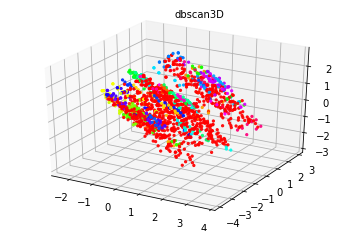

In [104]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.text2D(0.5, 0.95, 'dbscan3D', transform=ax.transAxes)
ax.scatter(new_X[:,0], new_X[:,1], new_X[:,2], c = Y, alpha = 0.9, s = 5)
plt.show()


Testing with sklearn

In [105]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS, cluster_optics_dbscan
from sklearn.preprocessing import StandardScaler

In [106]:
reduced_rate =0.5
from sklearn.decomposition.incremental_pca import IncrementalPCA
ncomponents = int(X_train.shape[1] * reduced_rate)
pca = IncrementalPCA(n_components = ncomponents)
X_train = pca.fit_transform(X_train) 

In [107]:
db = DBSCAN(eps=1.0, min_samples=3).fit(X_train)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print(labels)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

[  0  -1   0 ... 130  56  73]
Estimated number of clusters: 132
Estimated number of noise points: 939


[(0.6196078431372549, 0.00392156862745098, 0.25882352941176473, 1.0), (0.7803152633602461, 0.182160707420223, 0.2968089196462899, 1.0), (0.894886582083814, 0.3334871203383314, 0.28673587081891583, 1.0), (0.9665513264129182, 0.49742406766628217, 0.295040369088812, 1.0), (0.9922337562475971, 0.6861976163014224, 0.38362168396770463, 1.0), (0.9951557093425606, 0.8322952710495963, 0.5063437139561706, 1.0), (0.9982314494425221, 0.9451749327181853, 0.6570549788542868, 1.0), (0.9711649365628605, 0.9884659746251442, 0.7040369088811996, 1.0), (0.8838139177239526, 0.9534025374855826, 0.5997693194925028, 1.0), (0.7114186851211075, 0.8832756632064592, 0.6348327566320646, 1.0), (0.516724336793541, 0.8064590542099193, 0.6453671664744329, 1.0), (0.3280276816608997, 0.6805074971164936, 0.6802768166089965, 1.0), (0.21299500192233756, 0.5114186851211072, 0.730795847750865, 1.0), (0.34832756632064593, 0.33610149942329876, 0.647750865051903, 1.0), (0.3686274509803922, 0.30980392156862746, 0.635294117647058

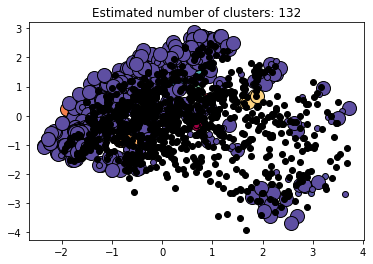

In [108]:
# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
#print(unique_labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 10, len(unique_labels))]
print(colors)
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X_train[class_member_mask & core_samples_mask]
    #print(xy)
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X_train[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()